## Analyse af forskellige depoter ved forskellige depotstørrelser og tidshorisont
08/12/2020

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('/home/jovyan/work/dkfinance_modeller'))
if module_path not in sys.path:
    sys.path.append(module_path)
import os
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,}'.format
import seaborn as sns
import pdb

import dkfinance_modeller.aktieskat.depotmodel as depotmodel
import dkfinance_modeller.aktieskat.kurtage as kurtage
import dkfinance_modeller.aktieskat.skat as skat
import dkfinance_modeller.aktieskat.vaerdipapirer as værdipapirer
import dkfinance_modeller.aktieskat.valuta as valuta
import dkfinance_modeller.utility.formler as formler

Opsætning af depoter

In [2]:
def depoter(kapital: float, optimering: float) -> Tuple[depotmodel.DepotModel, depotmodel.DepotModel]:
    """Definerer depoter.

    Returns:
      [depottype, 
      Depot objekt,
      udb_variable: [udbytte efter leak, udb_md, udb_år, ekstra udb andel, skatte optimering]
    """
    etf =     værdipapirer.ETF(kurs=100, åop=0.12 / 100, beskatningstype="lager"),       [0.85, 0, 0, 0, 0] 
    imb =     værdipapirer.ETF(kurs=100, åop=0.55 / 100, beskatningstype="realisation"), [0.85, 0, 1, 0.3, optimering]
    diy =     værdipapirer.ETF(kurs=100, åop=0.4 / 100,  beskatningstype="realisation"), [1.00, 1, 0, 0, optimering]
    pension = værdipapirer.ETF(kurs=100, åop=0.12 / 100, beskatningstype="lager"),       [0.85, 0, 0, 0, 0] 
    ask =     værdipapirer.ETF(kurs=100, åop=0.12 / 100, beskatningstype="lager"),       [0.85, 0, 0, 0, 0] 
    mix1 =     værdipapirer.ETF(kurs=100, åop=0.12 / 100, beskatningstype="lager"),       [0.85, 0, 0, 0, 0] 
    mix2 =     værdipapirer.ETF(kurs=100, åop=0.55 / 100, beskatningstype="realisation"), [0.85, 0, 1, 0.3, 0]
    skat_fri = skat.Skat("aktie")
    #skat_fri.progressionsgrænse = 110600
    skat_pension = skat.Skat("pension")
    skat_ask = skat.Skat("ask")
    etf = ['etf', depotmodel.DepotModel(
        kapital=kapital,
        kurtagefunktion=kurtage.saxo_kurtage_bygger(
            valuta="euro", valutakurs=7.44, underkonto=True),
        skatteklasse=skat_fri,
        minimumskøb=5000,
        ETFer=[etf[0]],
        ETF_fordeling=[1.0],
        valutafunktion=valuta.saxo_underkonto_kurtage,
    ), [etf[1]]]
    imb = ['imb', depotmodel.DepotModel(
        kapital=kapital,
        kurtagefunktion=kurtage.saxo_kurtage_bygger(valuta="Dkk"),
        skatteklasse=skat_fri,
        minimumskøb=5000,
        ETFer=[imb[0]],
        ETF_fordeling=[1.0],
    ), [imb[1]]]
    diy = ['diy', depotmodel.DepotModel(
        kapital=kapital,
        kurtagefunktion=kurtage.saxo_kurtage_bygger(
            valuta="euro", valutakurs=7.44, underkonto=True),
        skatteklasse=skat_fri,
        minimumskøb=5000,
        ETFer=[diy[0]],
        ETF_fordeling=[1.0],
    ), [diy[1]]]
    pension = ['pension', depotmodel.DepotModel(
        kapital=kapital,
        kurtagefunktion=kurtage.saxo_kurtage_bygger(
            valuta="euro", valutakurs=7.44, underkonto=True),
        skatteklasse=skat_pension,
        minimumskøb=5000,
        ETFer=[pension[0]],
        ETF_fordeling=[1.0],
        valutafunktion=valuta.nordnet_valutakonto_kurtage,
    ), [pension[1]]]
    ask = ['ask', depotmodel.DepotModel(
        kapital=kapital,
        kurtagefunktion=kurtage.saxo_kurtage_bygger(
            valuta="euro", valutakurs=7.44, underkonto=False),
        skatteklasse=skat_ask,
        minimumskøb=5000,
        ETFer=[ask[0]],
        ETF_fordeling=[1.0],
        valutafunktion=valuta.saxo_underkonto_kurtage,
    ), [ask[1]]]
    mix = ['mix', depotmodel.DepotModel(
        kapital=kapital,
        kurtagefunktion=kurtage.saxo_kurtage_bygger(
            valuta="euro", valutakurs=7.44, underkonto=True),
        skatteklasse=skat_fri,
        minimumskøb=5000,
        ETFer=[mix1[0], mix2[0]],
        ETF_fordeling=[0.1,0.9],
        valutafunktion=valuta.saxo_underkonto_kurtage,
    ), [mix1[1], mix2[1]]]
    return [etf, imb, mix, diy, pension, ask] #depoter, udbytte parametre
    #return [diy] #depoter, udbytte parametre

In [32]:
def output(dep):
    out = [    
    'Totalværdi: ' + str(dep.total_salgsværdi(medregn_fradrag=True)), 
    'Ubeskattet: ' + str(dep.ubeskattet), 
    'Kapital: ' + str(dep._kapital), 
    'Antal Værdipapirer: ' + str(dep.ETFer[0].antal_værdipapirer), 
    'Totalværdi: ' + str(dep.ETFer[0].antal_værdipapirer * dep.ETFer[0].kurs,dep.ETFer[0].kurs), 
    'Totalværdi: ' + str(dep.ETFer[0].beskattet_kurs), 
    'Totalværdi: ' + str(dep.måned)
       
    ]
    return out
outsample = pd.DataFrame(list(str('') * 10), columns = range(0,12)) 

Diverse detailjer om depotet

In [53]:
def output(dep):
    print('Totalværdi: ' , dep.total_salgsværdi(medregn_fradrag=True) , '\n', 
    'Ubeskattet: ' , dep.ubeskattet,  '\n', 
    'Kapital: ' , dep._kapital,  '\n', 
    'Antal Værdipapirer: ' , dep.ETFer[0].antal_værdipapirer,  '\n', 
    'Kursværdi: ' , dep.ETFer[0].antal_værdipapirer * dep.ETFer[0].kurs,dep.ETFer[0].kurs,  '\n', 
    'Kurs: ' , dep.ETFer[0].beskattet_kurs,  '\n', 
    'Måned: ' , dep.måned
    )    

Beregning af slutværdi

In [5]:
def run(skat_optimering, end_year):
    """Run analysis.
    Input:
    skat_optimering: 
    end_year: target year for analysis

    Returns:
      Out2: Dataframe of monthly value after tax per depot type
    """
    data_raw = np.genfromtxt("SP500.csv", delimiter=";")
    data = data_raw[500:] #include 1930 bear market
    #data = data_raw[1700:1750] #faster subset
    out = []
    details = []

    for kapital in [100000, 400000]:
        for j, antal_år in enumerate([end_year]):
            for start in range(0, len(data)):
                deps = depoter(kapital, skat_optimering) 
                for d_nr, dep in enumerate(deps):
                    year = 0
                    kurs_år = [0] * len(dep[1].ETFer)
                    udb_år = [0] * len(dep[1].ETFer)
                    for idx, i in enumerate(range(start , start + 12 * antal_år) ):
                        kurs_perc = data[(i + 1)%len(data), 3]
                        udb_perc = data[(i + 1)%len(data), 4]
                        kurs_md = []
                        udb_md = []
                        """Final month where taxes are due and yearly dividend is payed out"""
                        if (idx +1) % 12 == 0: 
                            for etf_nr, etf in enumerate(dep[1].ETFer):
                                leak, udbetal_md, udbetal_år, udbetal_ekstra, optimering = dep[2][etf_nr]
                                udb_ekstra = udbetal_år * udb_år[etf_nr] + max(0, udbetal_ekstra * kurs_år[etf_nr]) 
                                """raw udbytte efter div leak uden hensygen til forskydning """
                                raw_kurs_md = etf.kurs * kurs_perc
                                raw_udb_md = leak * etf.kurs * udb_perc
                                """endelig kurs og udbytte"""
                                kurs_md = kurs_md + [raw_kurs_md + (1-udbetal_md) * raw_udb_md - udb_ekstra]
                                udb_md = udb_md + [udbetal_md * raw_udb_md + udb_ekstra]
                            if optimering > (end_year - year):
                                if sum(udb_md) < dep[1].skatteklasse.progressionsgrænse:
                                    urealiseret = dep[1].ubeskattet + sum([x.lagerrealisering(ændre_kurs=False) for x in dep[1].ETFer])
                                    #start tax optimizing if unrealized gains is higher than half the progression limit for the rest of the period
                                    urealiseret_optimeret = ((end_year - year)/2 * dep[1].skatteklasse.progressionsgrænse)
                                    if urealiseret > urealiseret_optimeret:
                                        frivillig_udb = max(0, dep[1].skatteklasse.progressionsgrænse - sum(udb_md) )
                                        for etf_nr, target in enumerate(dep[1].ETF_target_fordeling):
                                            udb_md[etf_nr] += target * frivillig_udb / (dep[1].ETFer[etf_nr].kurs * dep[1].ETFer[etf_nr].antal_værdipapirer)
                                            kurs_md[etf_nr] -= target * frivillig_udb / (dep[1].ETFer[etf_nr].kurs * dep[1].ETFer[etf_nr].antal_værdipapirer)
                            dep[1].afkast_månedlig(kurs_md, udb_md)
                            year += 1
                            kurs_år = [0] * len(dep[1].ETFer)
                            udb_år = [0] * len(dep[1].ETFer)
                            try: 
                                dep[1].skatteklasse.progressionsgrænse *= 1.02
                            except:
                                pass
                            if year > 1:
                                out.append([kapital,year, dep[1].måned,start, dep[0], dep[1].total_salgsværdi(medregn_fradrag=True)])
                        #"""Other months of the year"""
                        else: 
                            for etf_nr, etf in enumerate(dep[1].ETFer):
                                leak, udbetal_md, udbetal_år, udbetal_ekstra, optimering = dep[2][etf_nr]
                                """raw udbytte efter div leak uden hensygen til forskydning """
                                raw_kurs_md = etf.kurs * kurs_perc
                                raw_udb_md = leak * etf.kurs * udb_perc
                                """endelig kurs og udbytte"""
                                kurs_md = kurs_md + [raw_kurs_md + (1-udbetal_md) * raw_udb_md]
                                udb_md = udb_md + [udbetal_md * raw_udb_md]
                                kurs_år[etf_nr] = kurs_år[etf_nr] + raw_kurs_md
                                udb_år[etf_nr] = udb_år[etf_nr] + raw_udb_md
                            dep[1].afkast_månedlig(kurs_md, udb_md)
                            #details.append([d_nr, etf_nr, kurs_md[0], udb_md[0]])
                            if year > 1:
                                out.append([kapital,year, dep[1].måned,start, dep[0], dep[1].total_salgsværdi(medregn_fradrag=True)])

    headers = ['kapital', 'year','måned',  'start', 'type', 'salgsværdi']
    dtypes = {'kapital': 'float64', 'year': 'int','måned': 'int', 'start': 'int64', 'type': 'category', 'salgsværdi' : 'float64'}
    out2 = pd.DataFrame(out)
    out2.columns = headers
    out2 = out2.astype(dtype=dtypes)
    out2['CAGR'] = ((out2['salgsværdi']/out2['kapital'])**(1/(out2['year']+out2['måned']/12.0)) -1).astype(float)
    out2['periode'] = (out2['year'] + out2['måned']/12).round(2)
    out2 = out2.set_index(['kapital', 'year', 'måned', 'start', 'type'])
    return out2

## Kørsel og analyse

In [6]:
out2 = run(4, 40)
out_median = out2.groupby(['kapital', 'year', 'måned', 'type']).median()

CAGR median over tid per depot og kapital

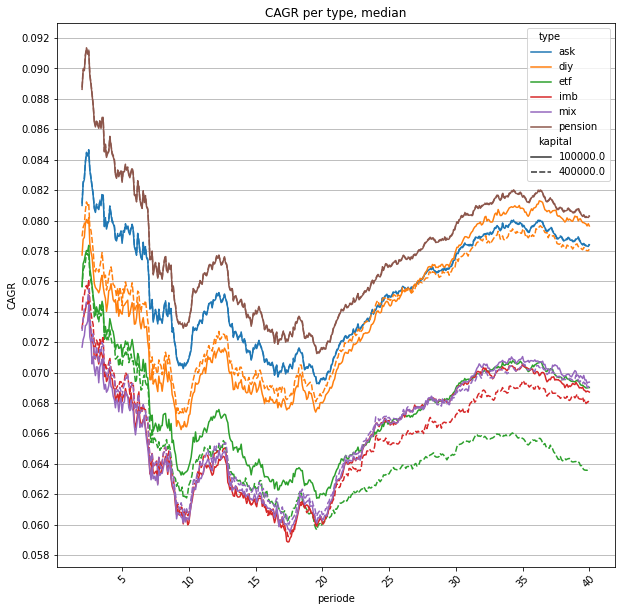

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.yaxis.grid(True, which = 'both' )
sns_plt = sns.lineplot(
    x="periode",
    y="CAGR",
    hue='type',
    style = 'kapital',
    ci = None,
    estimator=np.median,
    data=out2,
    ax =ax 
).set_title('CAGR per type, median')
plt.xticks(rotation=45)
ax.locator_params(nbins=20, axis='y')
plt.show()

CAGR gennemsnit over tid per depot og kapital

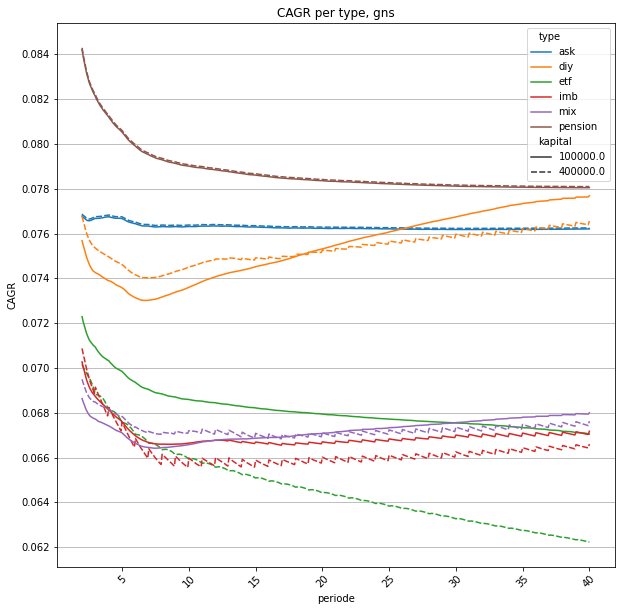

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.yaxis.grid(True, which = 'both' )
sns_plt = sns.lineplot(
    x="periode",
    y="CAGR",
    hue='type',
    style = 'kapital',
    ci = None,
    estimator=np.mean,
    data=out2,
    ax =ax 
).set_title('CAGR per type, gns')
plt.xticks(rotation=45)
ax.locator_params(nbins=20, axis='y')
plt.show()

## Pensionsdepot vs Frie midler

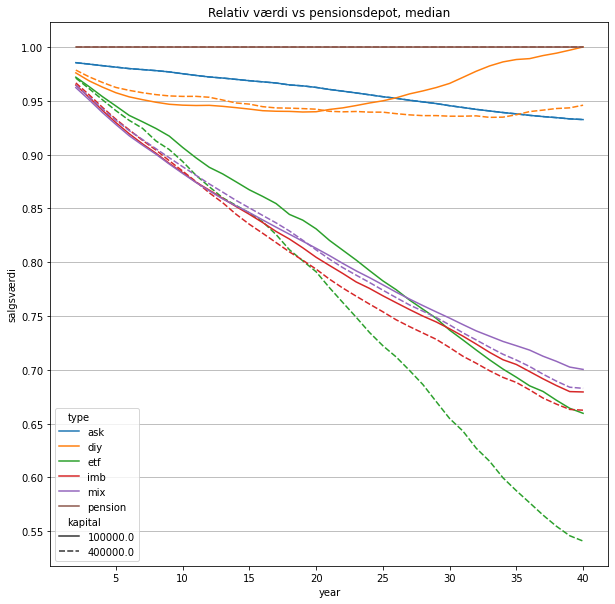

In [21]:
if True: 
    pension_vs_fri = out2[['salgsværdi']].loc(axis=0)[:,:,:,:,:].copy()
    pension_vs_fri = pension_vs_fri.unstack('type')
    #pension_vs_fri =  pension_vs_fri.droplevel(0, axis=1)
    numeric_cols = [col for col in pension_vs_fri if pension_vs_fri[col].dtype.kind != 'O']
    for col in numeric_cols:
        pension_vs_fri[col] = pension_vs_fri[col] / pension_vs_fri['salgsværdi', 'pension']
    pension_vs_fri = pension_vs_fri.stack()
    #pension_vs_fri

    fig, ax = plt.subplots(figsize=(10, 10))
    sns_plt = sns.lineplot(
        x="year",
        y="salgsværdi",
        hue='type',
        style = 'kapital',
        ci = None,
        estimator=np.median,
        data=pension_vs_fri,
        ax =ax 
    ).set_title('Relativ værdi vs pensionsdepot, median')
    ax.yaxis.grid(True, which = 'both' )    
    ax.locator_params(nbins=20, axis='y')
    plt.show()

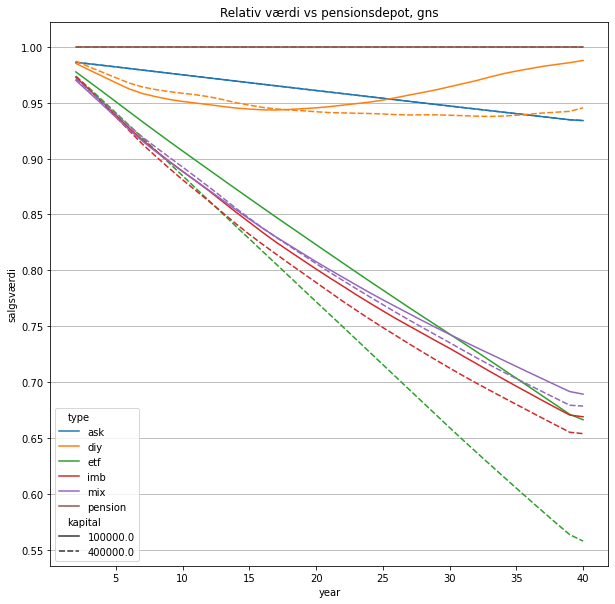

In [23]:
if True: 
    pension_vs_fri = out2[['salgsværdi']].loc(axis=0)[:,:,:,:,:].copy()
    pension_vs_fri = pension_vs_fri.unstack('type')
    numeric_cols = [col for col in pension_vs_fri if pension_vs_fri[col].dtype.kind != 'O']
    for col in numeric_cols:
        pension_vs_fri[col] = pension_vs_fri[col] / pension_vs_fri['salgsværdi', 'pension']
    pension_vs_fri = pension_vs_fri.stack()

    fig, ax = plt.subplots(figsize=(10, 10))
    sns_plt = sns.lineplot(
        x="year",
        y="salgsværdi",
        hue='type',
        style = 'kapital',
        ci = None,
        estimator=np.mean,
        data=pension_vs_fri,
        ax =ax 
    ).set_title('Relativ værdi vs pensionsdepot, gns')
    ax.yaxis.grid(True, which = 'both' )    
    ax.locator_params(nbins=10, axis='y')
    plt.show()